# Why DSLs?

<div>
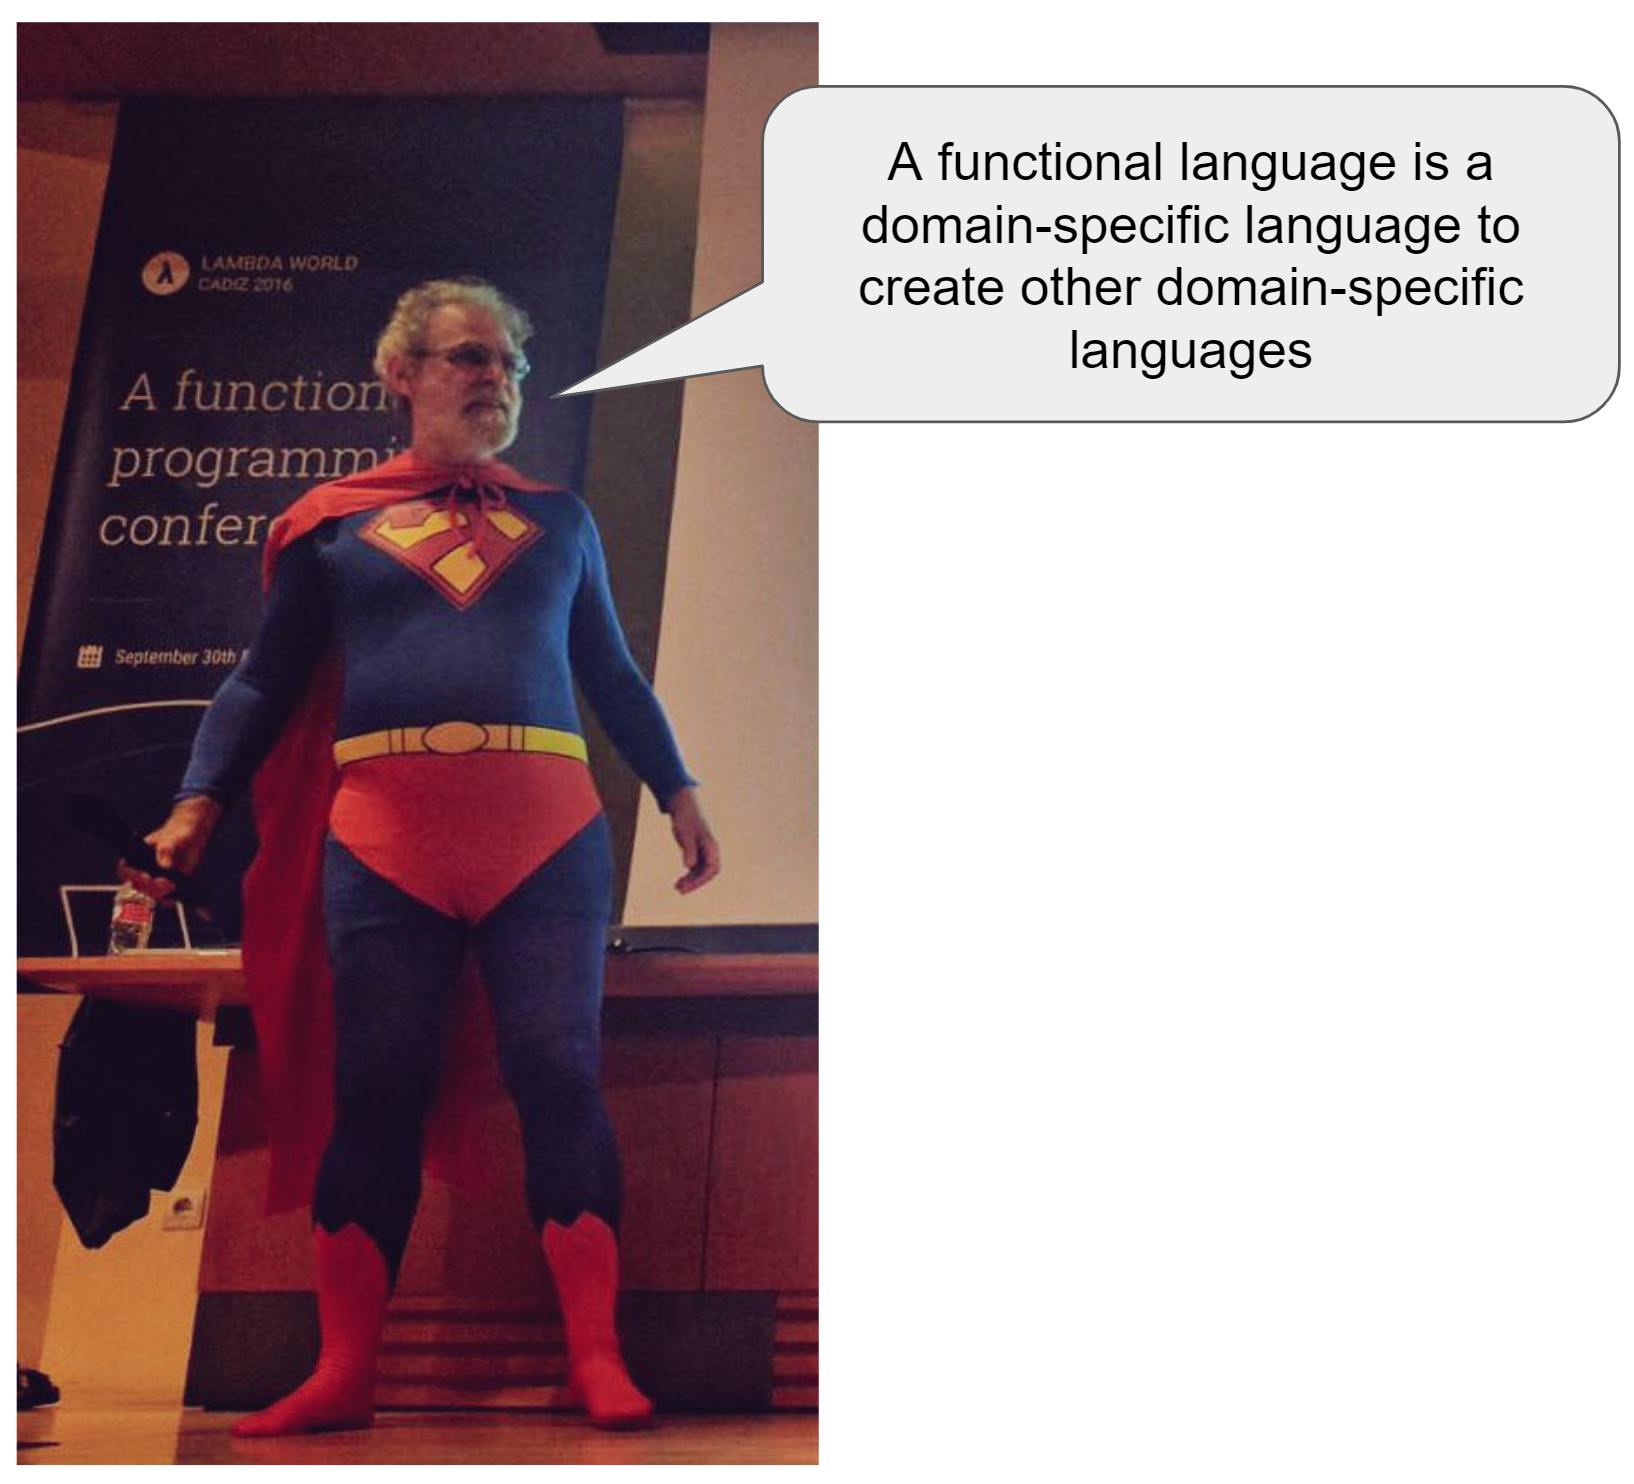
</div>

### Goals

The primary goal of this first notebook is to demonstrate the need for Domain-Specific Languages (DSLs) and the advantages of the embedded approach. Specifically, we will:

* Explain how DSLs contribute to problem-solving and computing in general
* Highlight the relationship between DSLs and functional programming
* Introduce the use case and techniques that will be used throughout the course


# The problem

We want to retrieve specific information from all the commits of a GitHub repository. The GitHub API provides the appropriate endpoint to begin with:

[https://api.github.com/repos/hablapps/doric/commits?page=0](https://api.github.com/repos/hablapps/doric/commits?page=0)

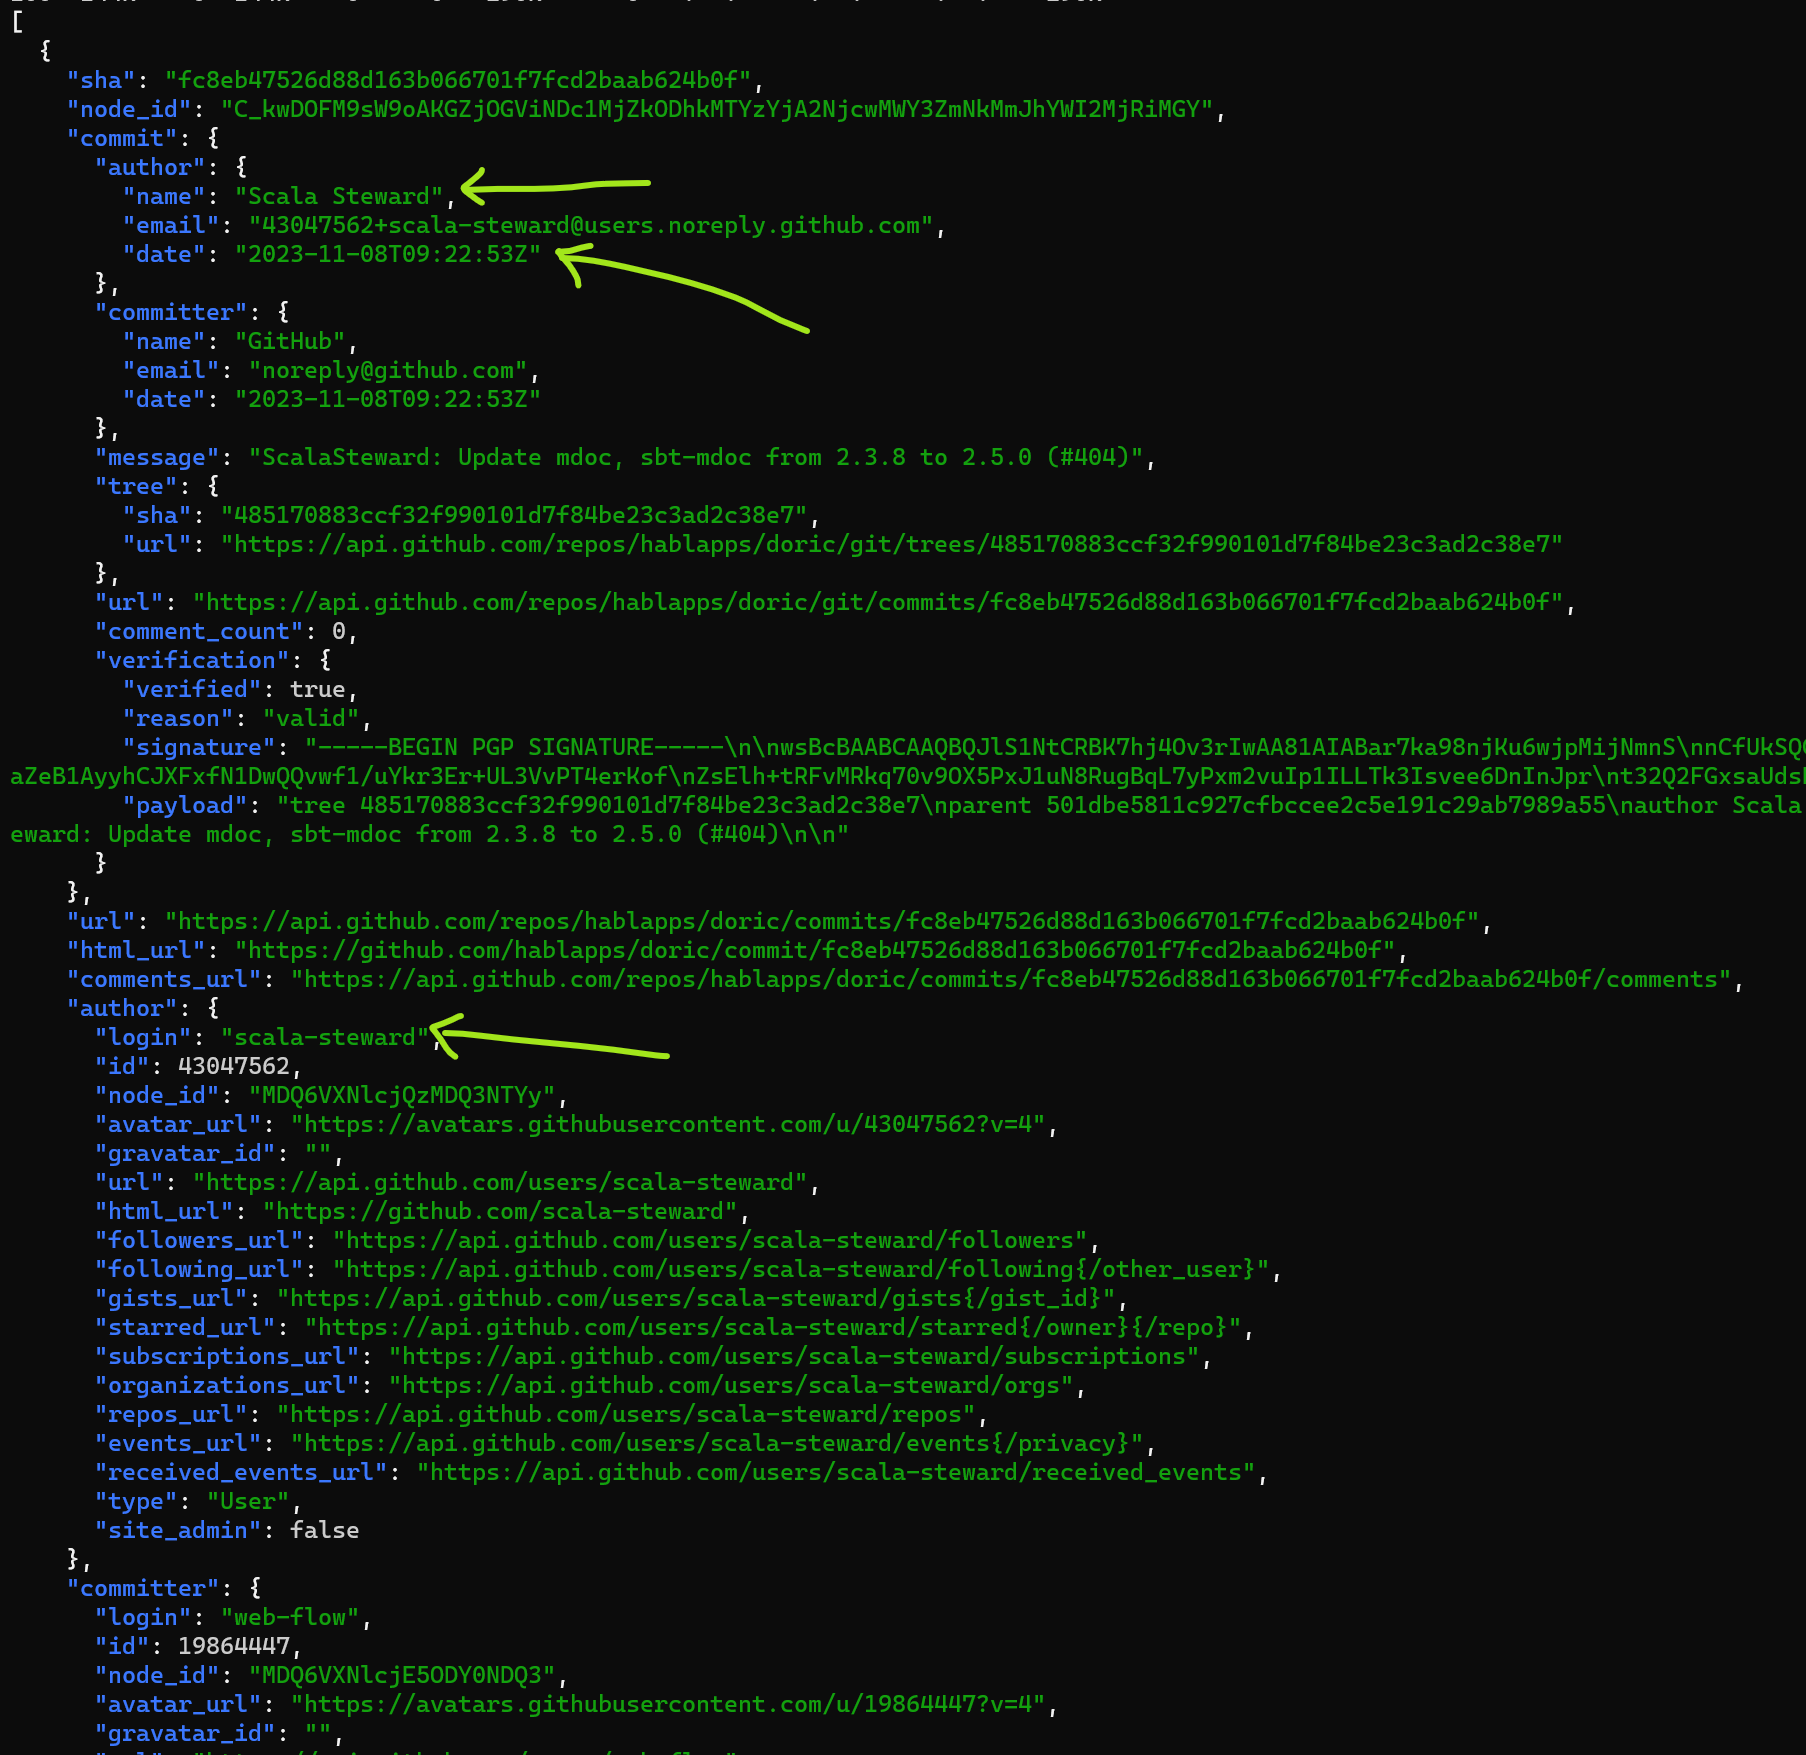

The endpoint returns a single array of commit messages, but we need a JSON Lines document of commits. Additionally, it provides more information than we require. Also, note that the endpoint is *paginated*, meaning we need to repeatedly call it with subsequent page numbers until we receive an empty array. 

We can abstract away this minor inconvenience by conceptualizing the solution in terms of *stream processing*. From this perspective, we can approach the problem in two steps: first, we create a stream of pages, and then we apply the necessary transformations to the data. However, note that this sequence of steps is purely conceptual: commits from the first page will be processed as soon as they're available, potentially even before the next page is retrieved. The streaming framework will handle this complexity behind the scenes.

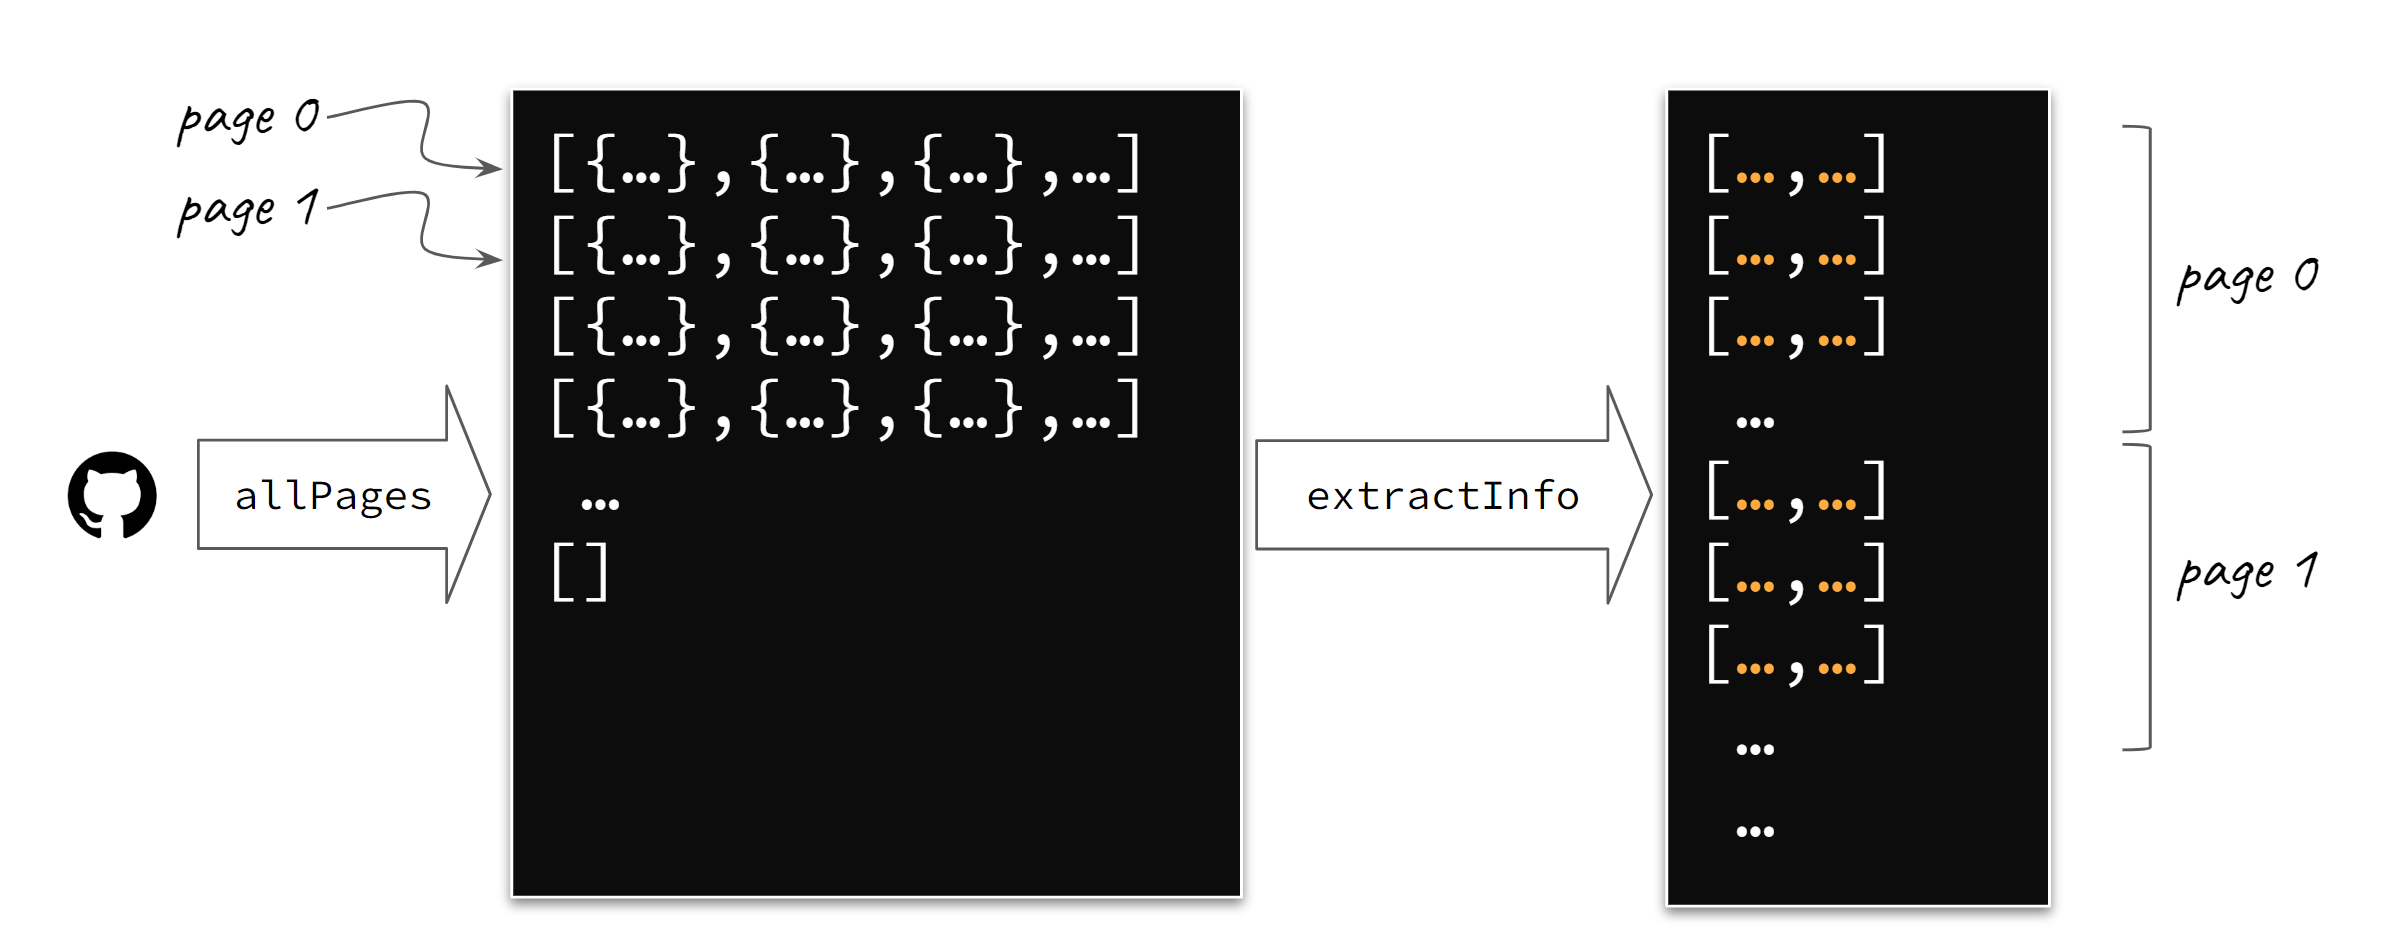

# The streaming language

How to implement our streaming solution? There are several alternatives in the Scala ecosystem: Akka Streams, ZIO Streams, Fs2, etc. We will demonstrate the solution to our problem using [fs2](https://fs2.io/#/), along with the support of the JSON library [circe](https://circe.github.io/circe/) and the optics library [Monocle](https://github.com/optics-dev/Monocle).

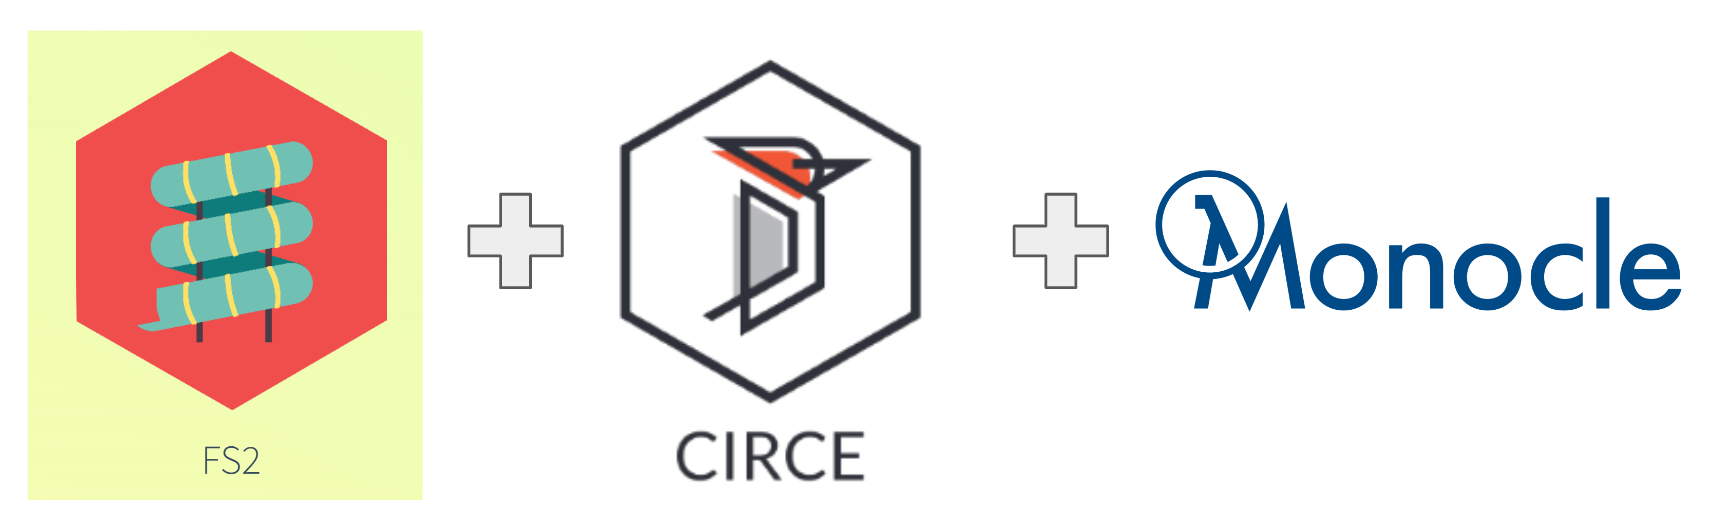

### `fs2` + `circe` + `monocle` solution

In [ ]:
import $ivy.`org.http4s::http4s-ember-client:1.0.0-M40`
import $ivy.`org.http4s::http4s-dsl:1.0.0-M40`
import $ivy.`org.http4s::http4s-circe:1.0.0-M40`
import $ivy.`co.fs2::fs2-core:3.8.0`
import $ivy.`co.fs2::fs2-io:3.8.0`
import $ivy.`io.circe::circe-parser:0.15.0-M1`
import $ivy.`io.circe::circe-generic:0.15.0-M1`
import $ivy.`org.slf4j:slf4j-nop:2.0.9`
import $ivy.`io.circe::circe-optics:0.15.0`
import $ivy.`dev.optics::monocle-macro:3.2.0`

In [ ]:
import fs2.{Pipe, Pull, Stream}
import fs2.io.net.Network
import cats.effect.{IO, Async}
import cats.effect.unsafe.IORuntime
import org.http4s.*, org.http4s.implicits._
import io.circe.Json
import io.circe.{`export` as _, Json, *}
import io.circe.parser._
import io.circe.syntax._
import io.circe.optics.JsonPath._
import org.typelevel.log4cats.LoggerFactory
import org.typelevel.log4cats.slf4j.Slf4jFactory
given LoggerFactory[IO] = Slf4jFactory.create[IO]

#### Some utilities

In [ ]:
def stream[F[_]: Async: Network: LoggerFactory](u: org.http4s.Uri, token: String): Stream[F, Json] = 
    import org.http4s.ember.client.EmberClientBuilder
    import io.circe.jawn.CirceSupportParser
    import org.http4s.headers.Authorization
    import org.http4s.{Method, Request}
    import org.typelevel.jawn.Facade
    import org.typelevel.jawn.fs2._

    given Facade[Json] = new CirceSupportParser(None, false).facade
    val authHeader =  Authorization(Credentials.Token(AuthScheme.Bearer, token))
    Stream.resource(EmberClientBuilder.default[F].build).flatMap{
        _.stream(Request[F](Method.GET, u).withHeaders(authHeader))
         .flatMap(_.body.chunks.parseJsonStream)
    }

In [ ]:
object IsArray: 
    def unapply(v: Json): Option[Vector[Json]] = 
        v.asArray

In [ ]:
extension [A](st: Stream[IO, A])
    def run(using IORuntime): List[A] = 
        st.compile.toList.unsafeRunSync()

In [ ]:
def log[F[_]: Async](msg: String): Stream[F, Unit] =
    Stream.eval(Async[F].delay(println(msg)))

### Stream generation

<div>
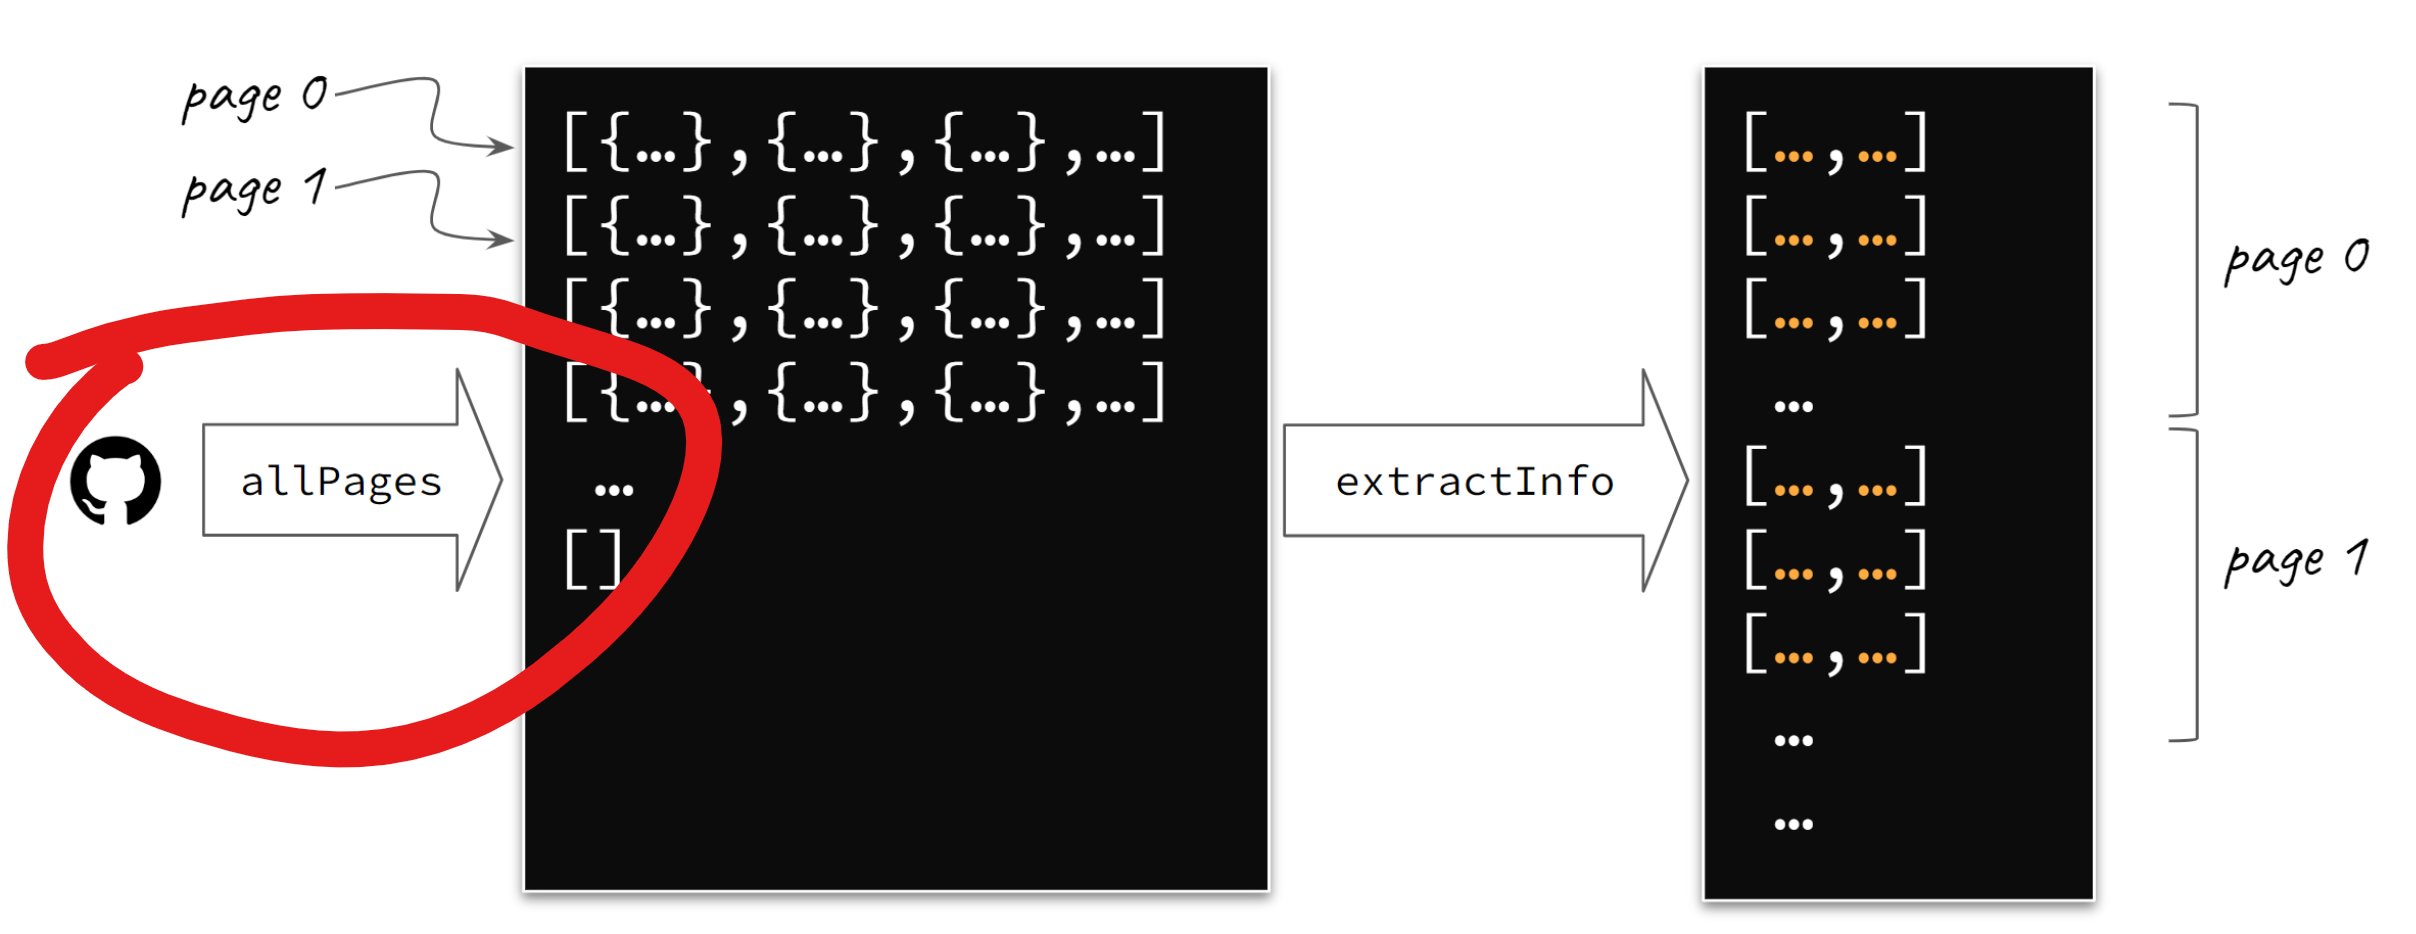
</div>

This implementation ensures that only the necessary pages are requested, which is a key feature of the *streaming* approach.

Please set the OS environment variable `BEARER_GITHUB_TOKEN` with your personal access token to run these examples.

In [ ]:
def allCommitPages[F[_]: Async: Network: LoggerFactory](repo: String): Stream[F, Json] =

    val bearerToken = scala.util.Properties.envOrElse("BEARER_GITHUB_TOKEN", "undefined")
    
    def newPage(i: Int): Stream[F, Json] = 
        log(s"> get page $i") >> 
        stream(Uri.unsafeFromString(s"$repo/commits?page=$i"), bearerToken)
    
    def go(i: Int, s: Stream[F,Json]): Pull[F, Json, Unit] =
        s.pull.uncons.flatMap:
            case Some((hd,tl)) =>
                hd(0) match
                    case IsArray(Vector()) => Pull.done
                    case _ => Pull.output(hd) >> go(i+1, tl ++ newPage(i))
            case None => Pull.done

    go(1, newPage(0)).stream

### Stream transformation

<div>
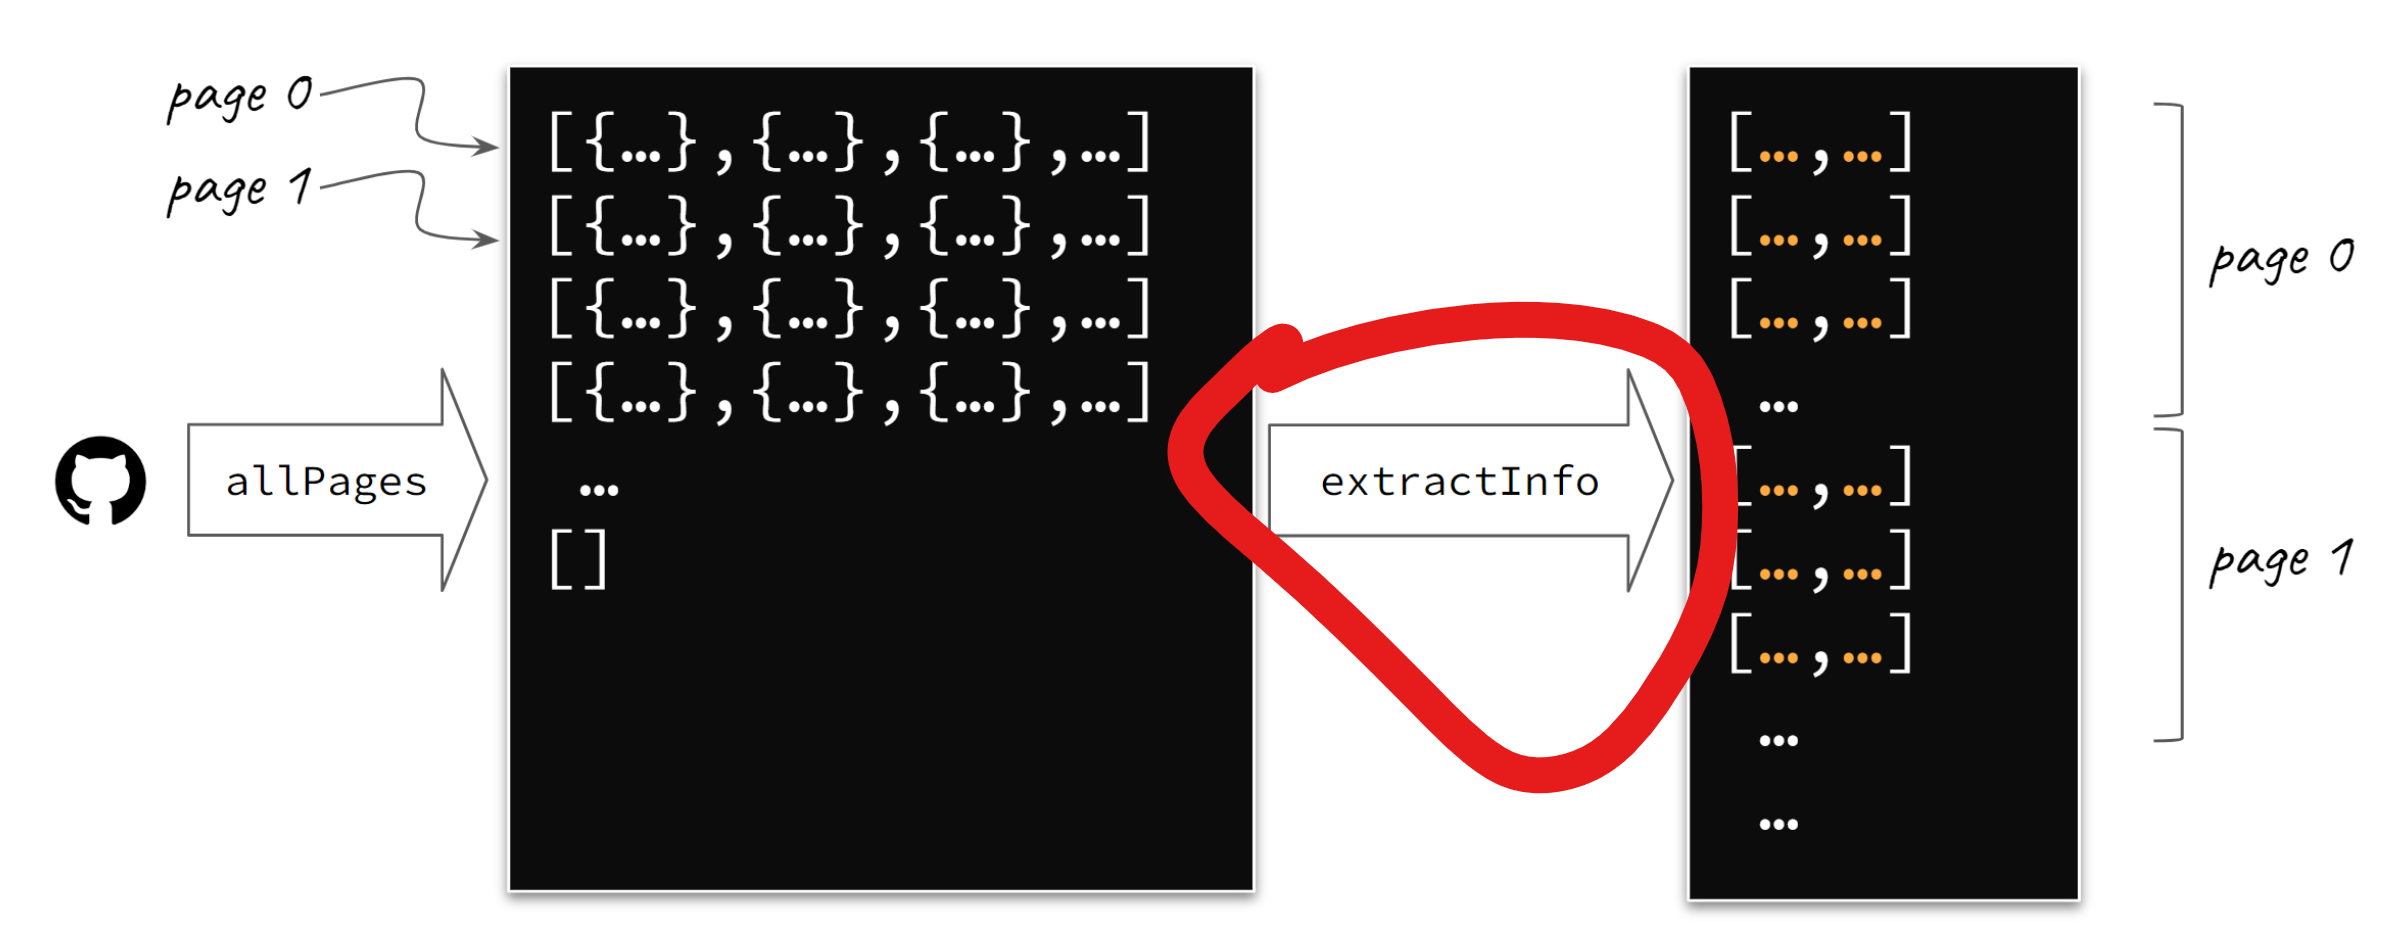
</div>

The extraction of the required information is a stream transformation, referred to as a *Pipe* in fs2 terminology.

In [ ]:
// extractInfo



### All together

In [ ]:
// commitInfoResults



This is a *pure* program, meaning it returns a streaming program that only constructs a program for a specific effect `F`, without performing any other actions:

In [ ]:
// commitInfoResults for IO effects



### Executing the streaming program

In [ ]:
import cats.effect.unsafe.implicits.global

This is actually done in two steps. First, we obtain an `IO` program:

In [ ]:
// IO program



Side effects are only produced when the `IO` program is executed:

In [ ]:
// Side effects!



#### Exercise
<div class="alert alert-info">
   Which is the size of the page? Test it empirically.
</div>

##### Solution

The number of commits per page is 30.

# Beyond streaming: `jq` solution

<div>
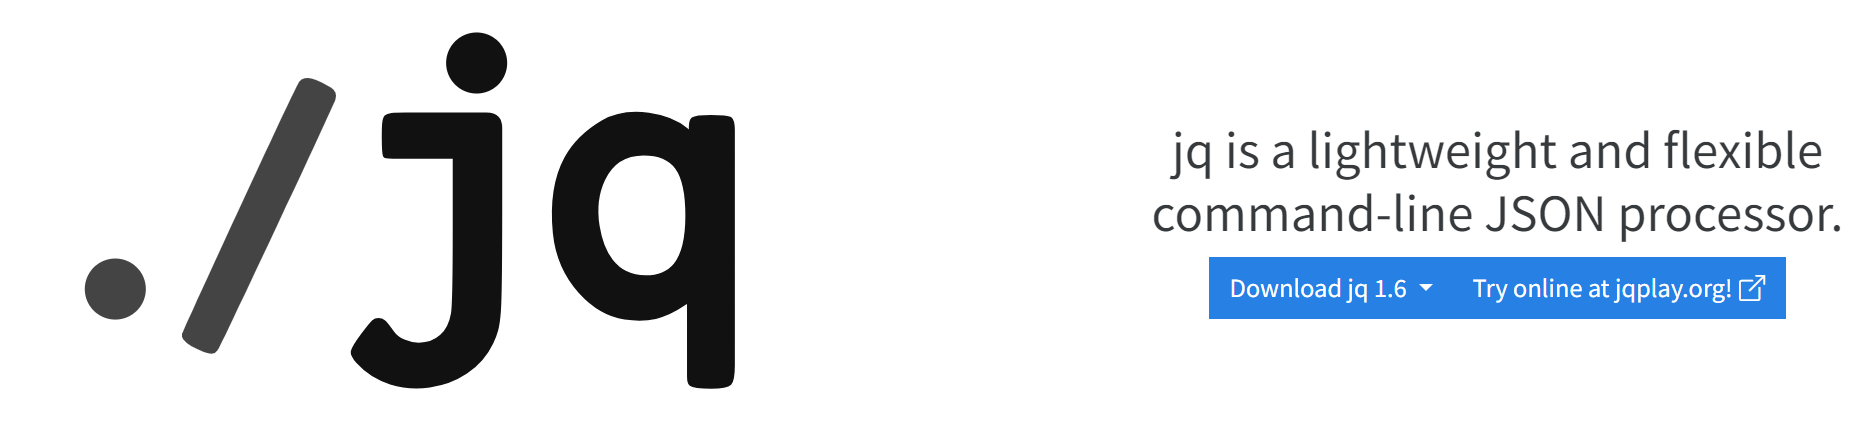
</div>

Jq is a DSL for programming transformations on JSON streams, known as filters. By using jq, we can implement the `extractInfo` step in a concise and easily understandable way:

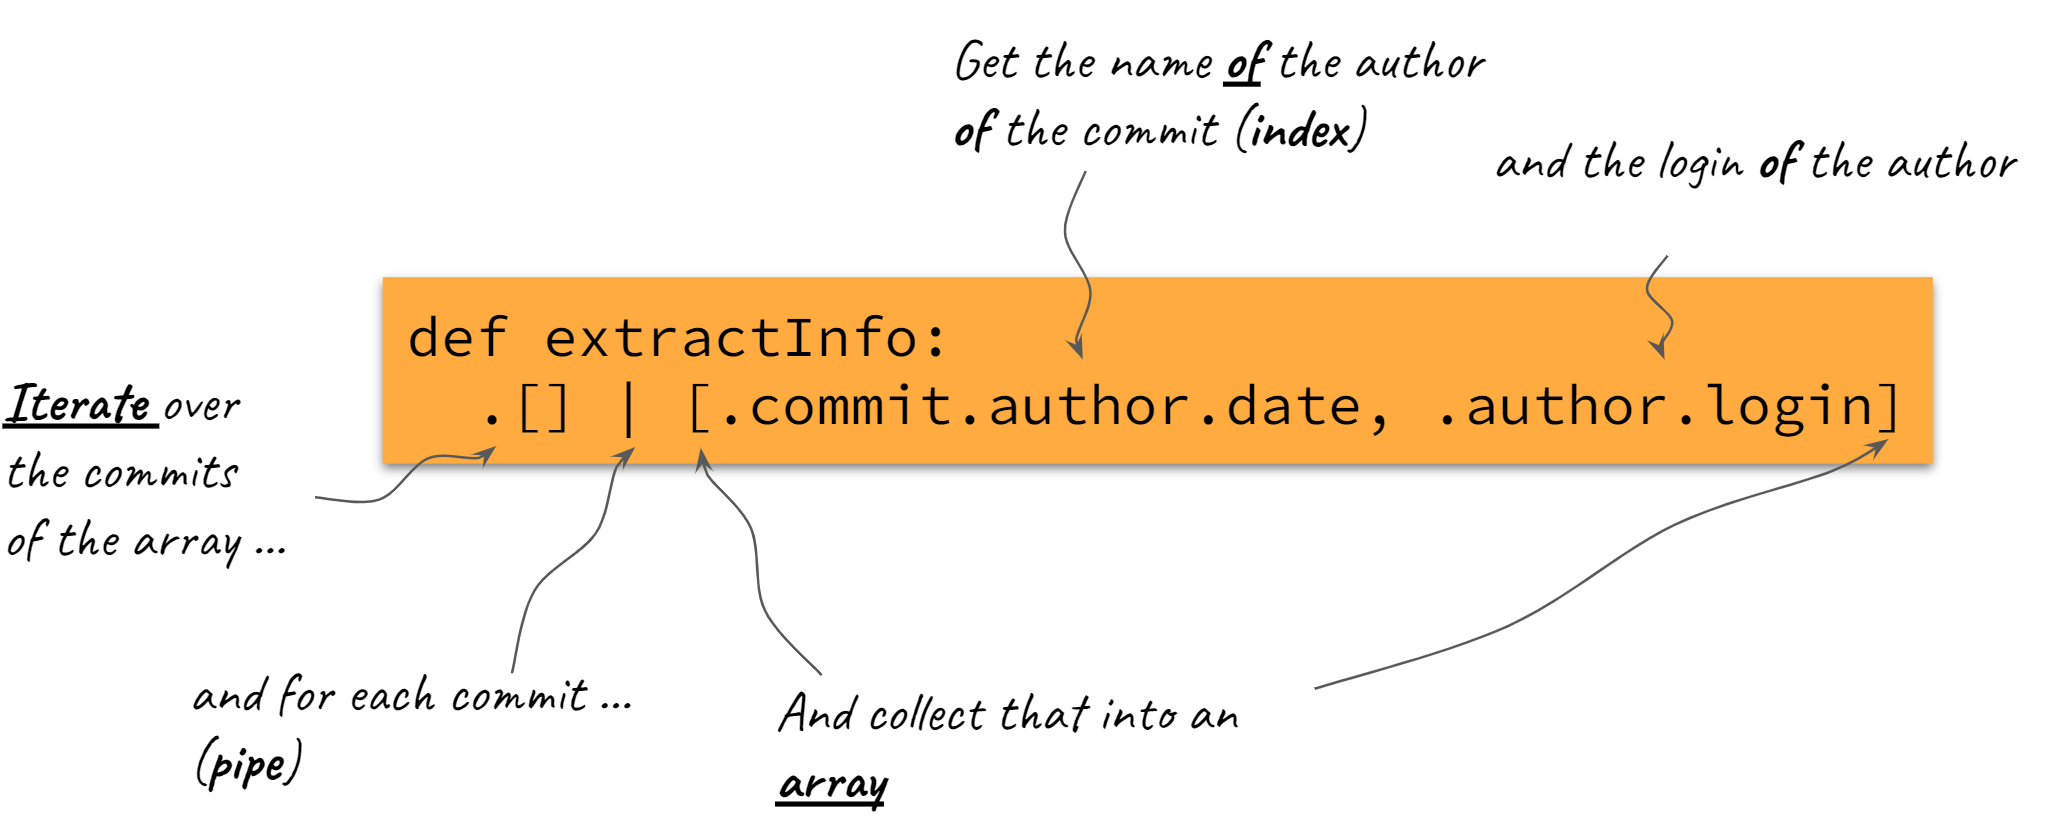

[Try it!](https://jqplay.org/s/RsLG7xIUQ-xwUVR)
You can find here the [manual](https://jqlang.github.io/jq/manual/)!

# Embedding jq in Scala

Two alternatives so far:

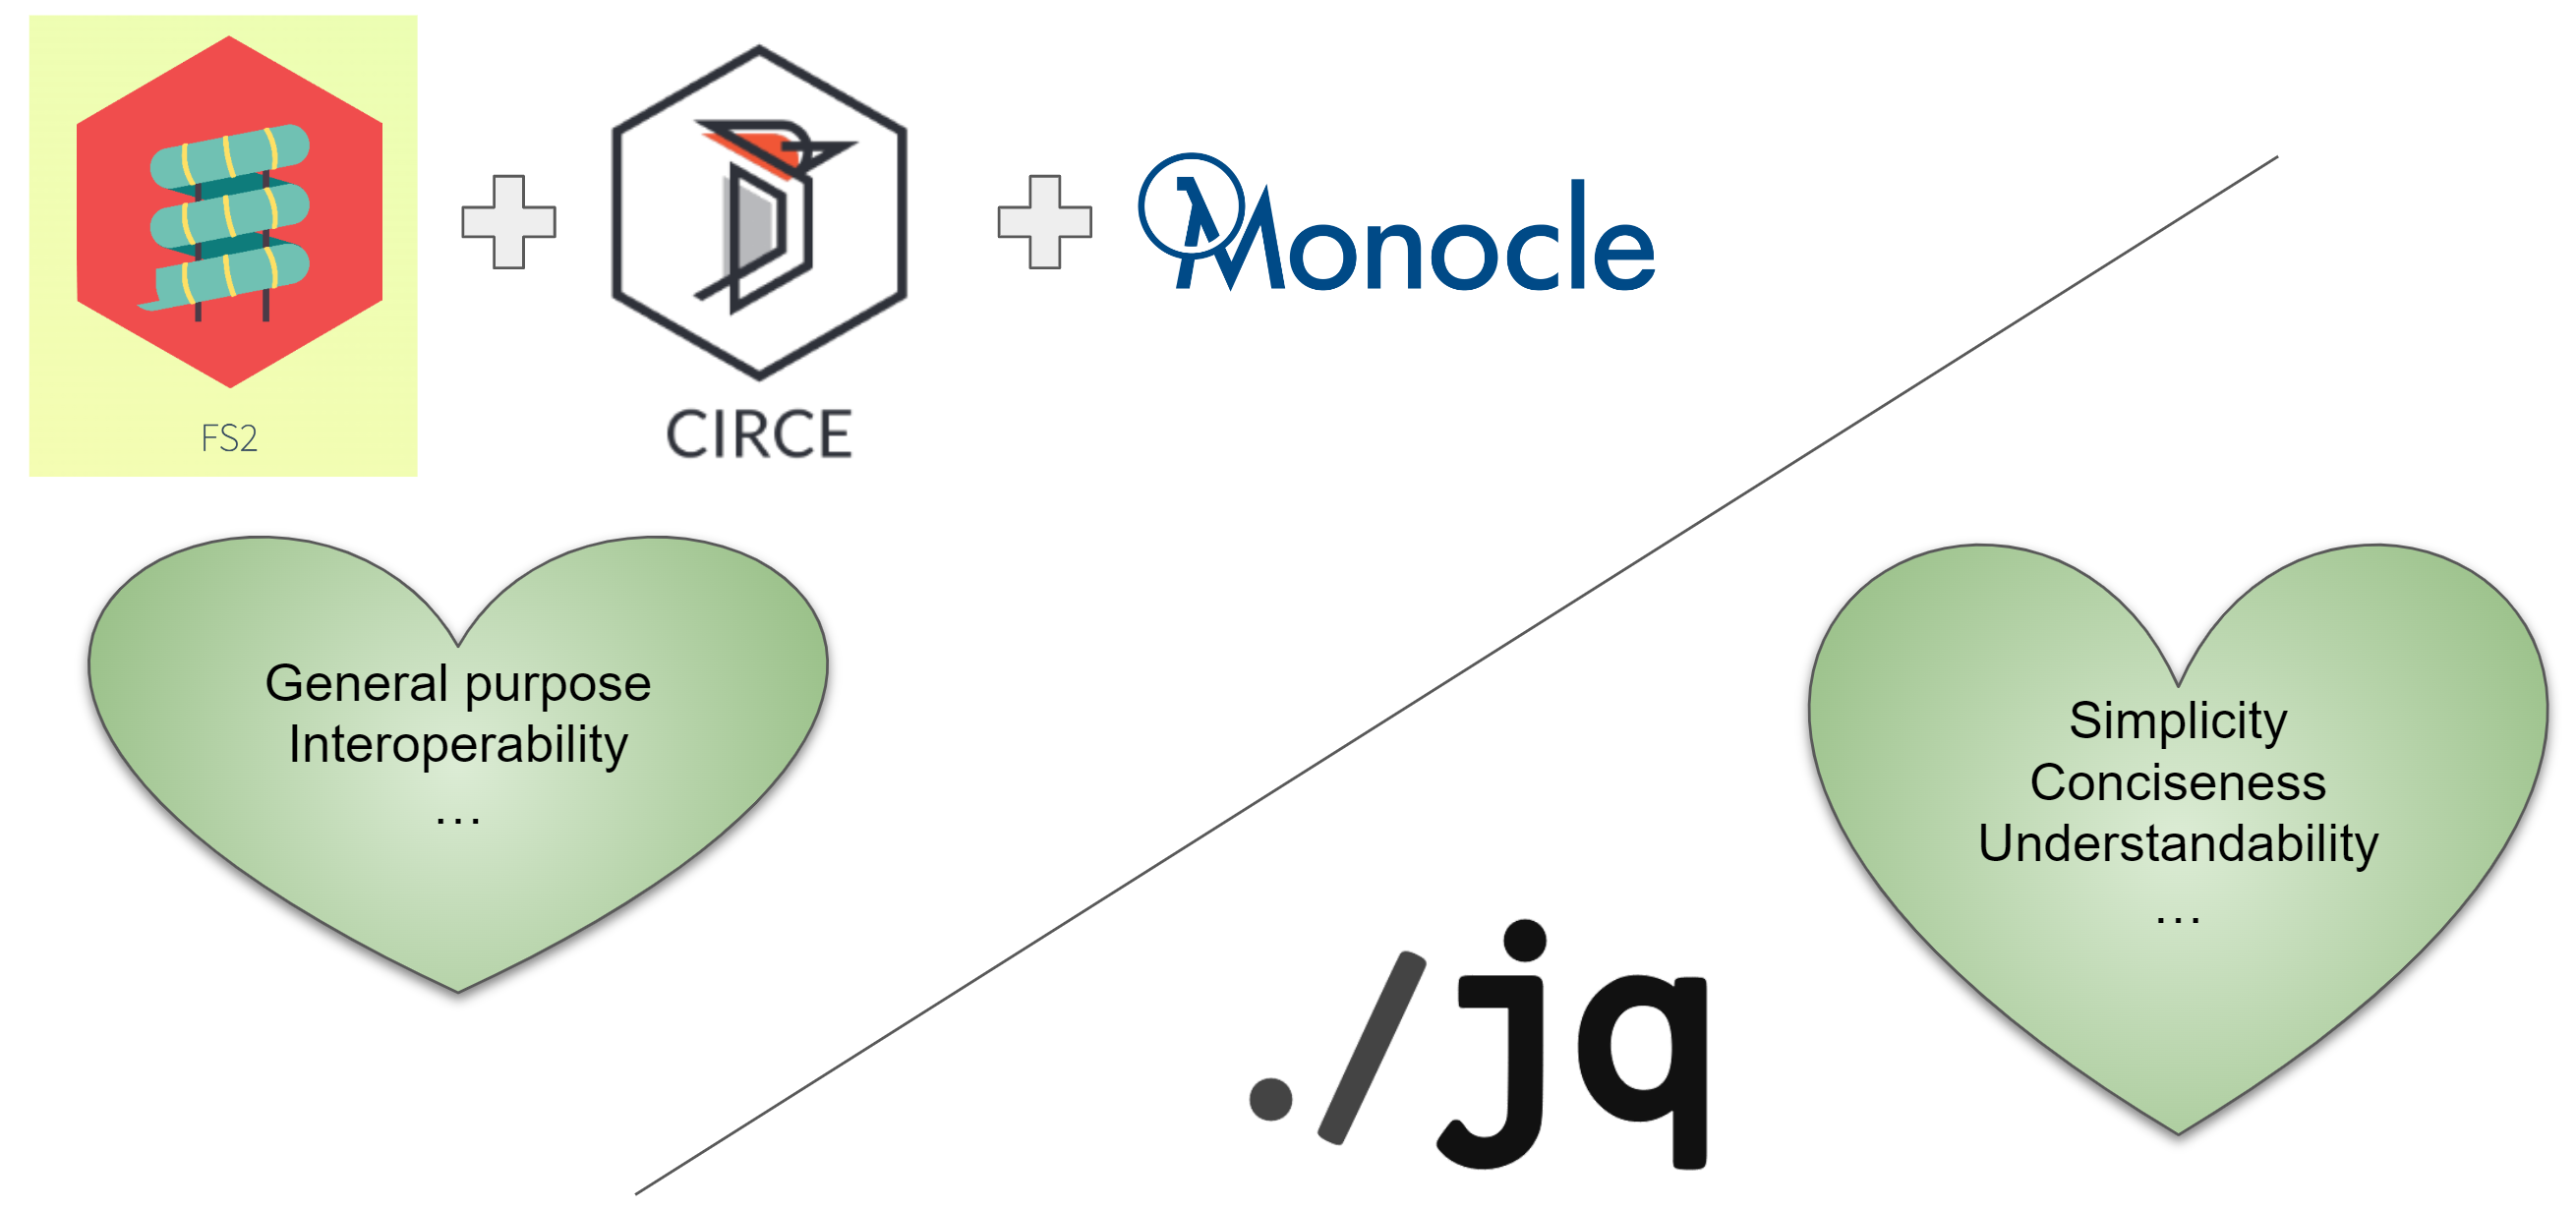

The best of both worlds:

<div>
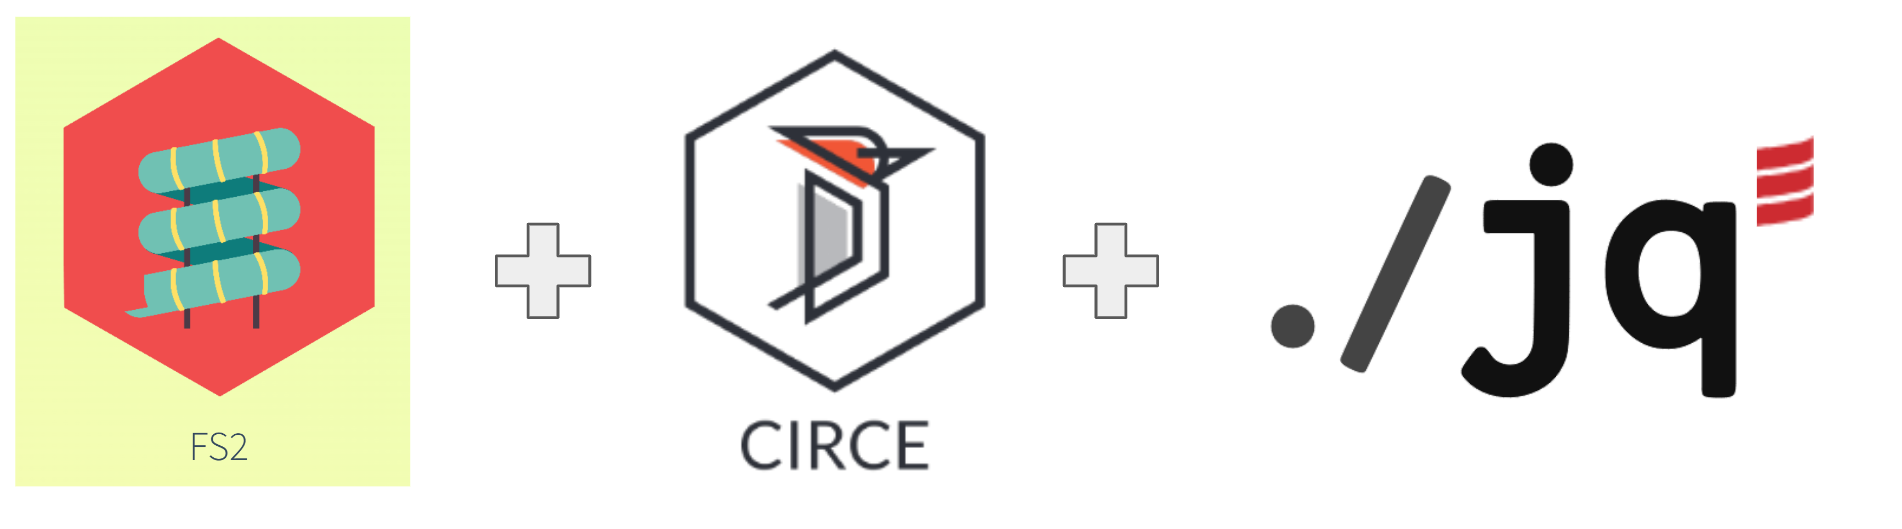
</div>

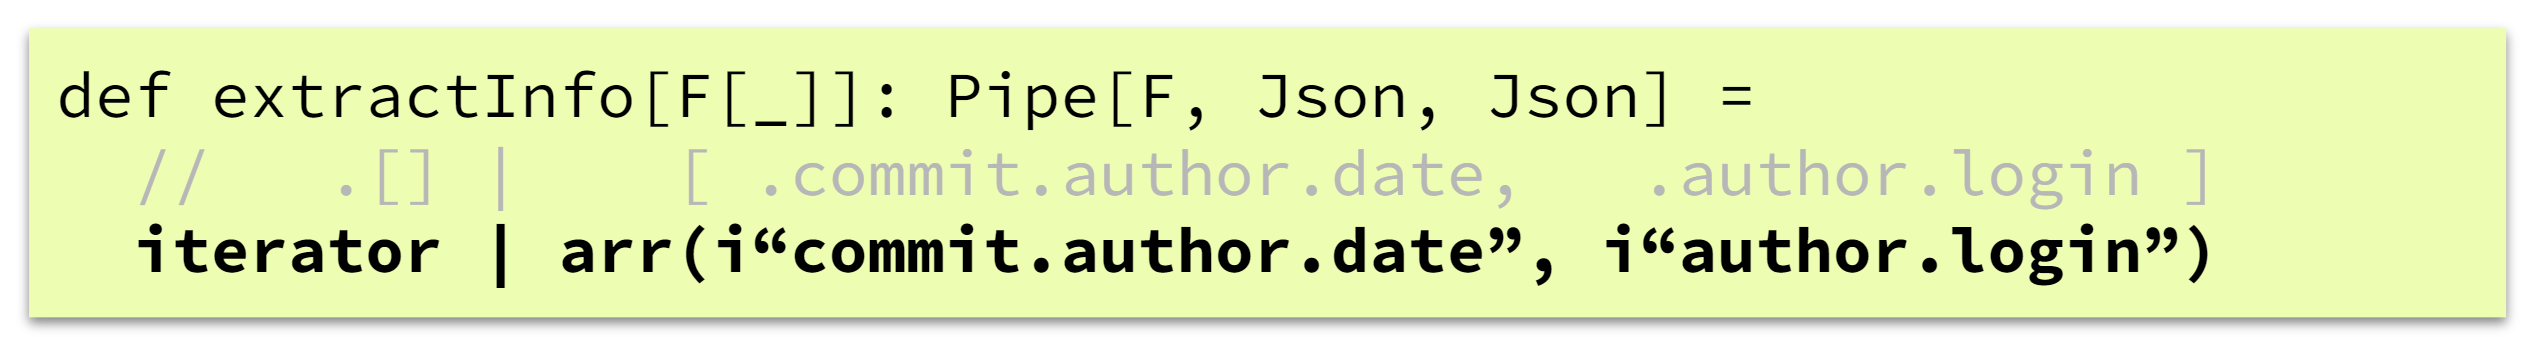

The approach:

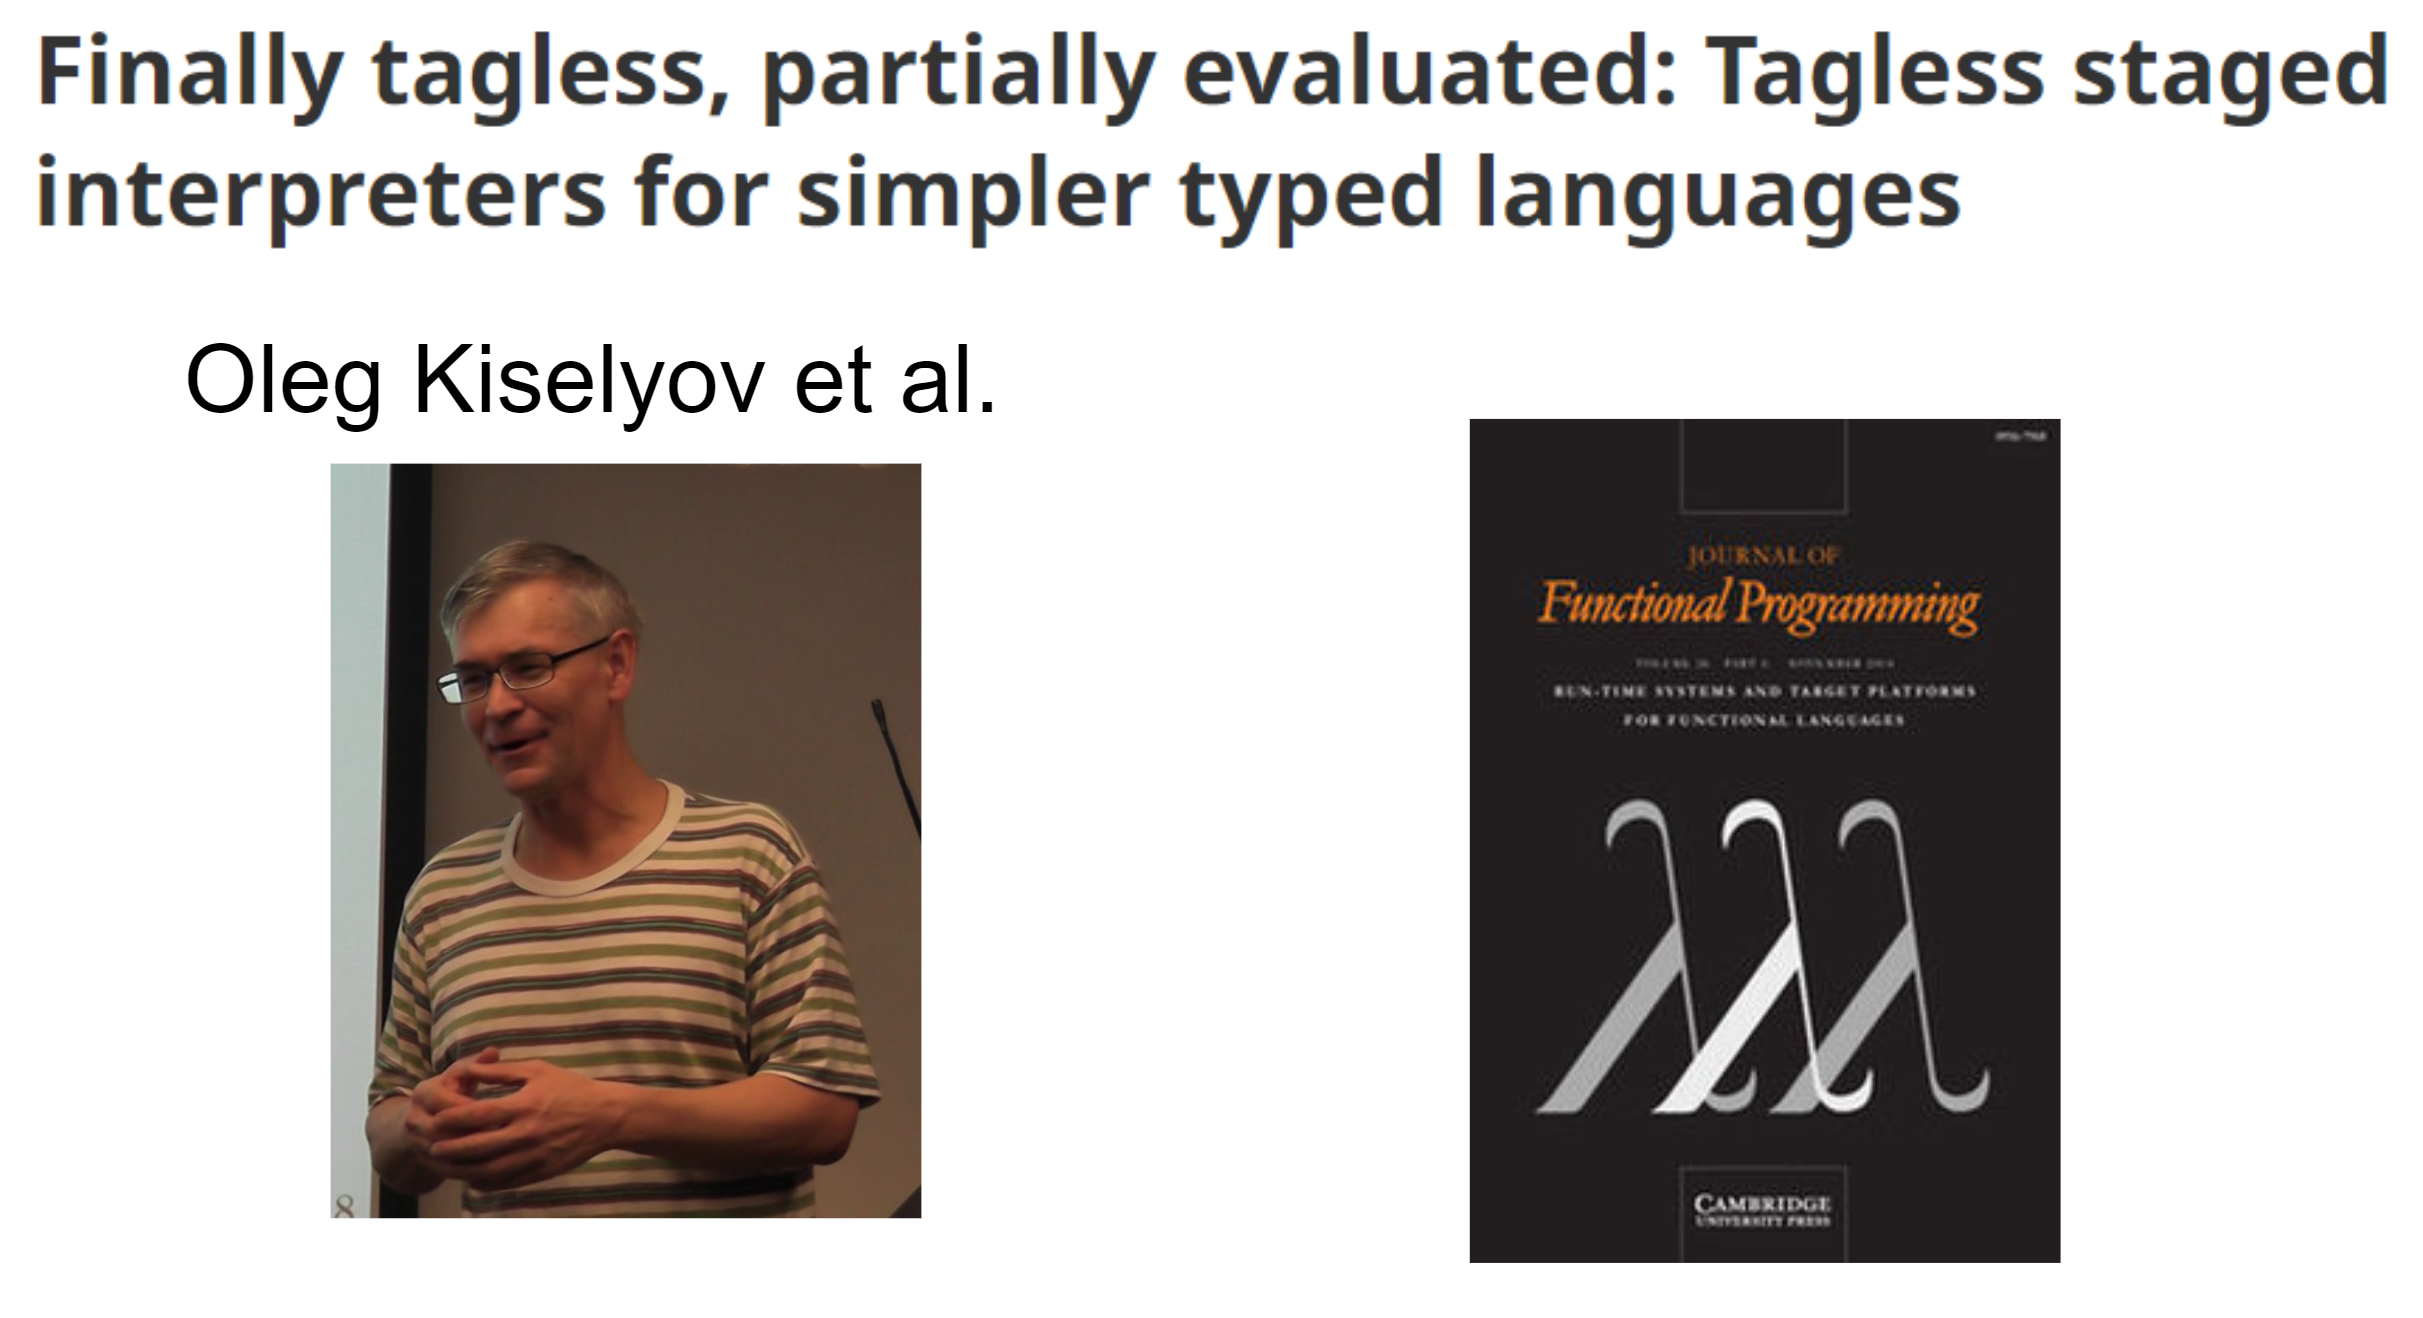

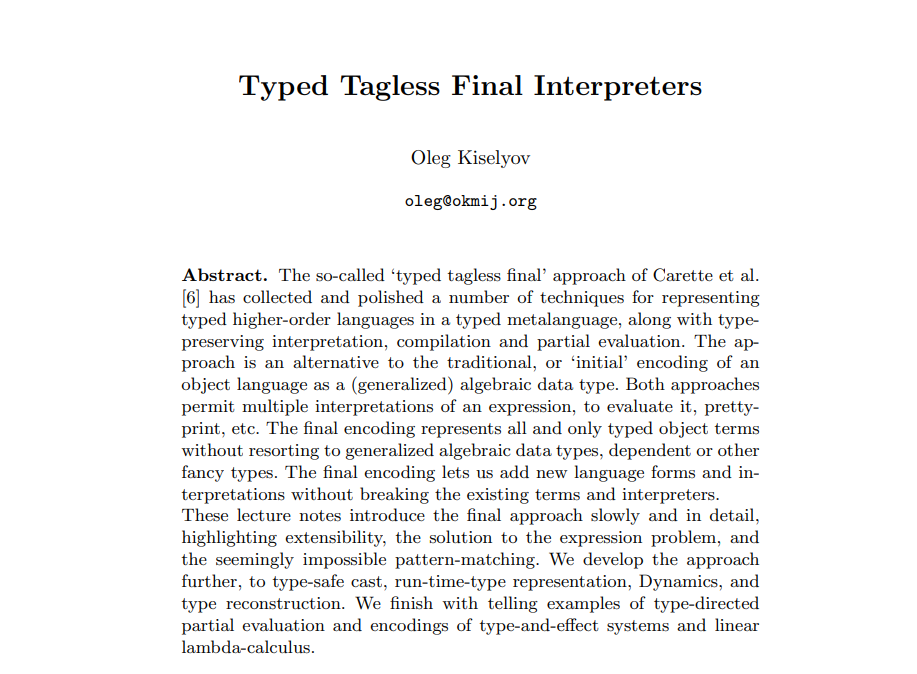
[link](https://okmij.org/ftp/tagless-final/course/lecture.pdf)

The tagless-final approach favours an incremental, step-by-step methodology for embedding DSLs:

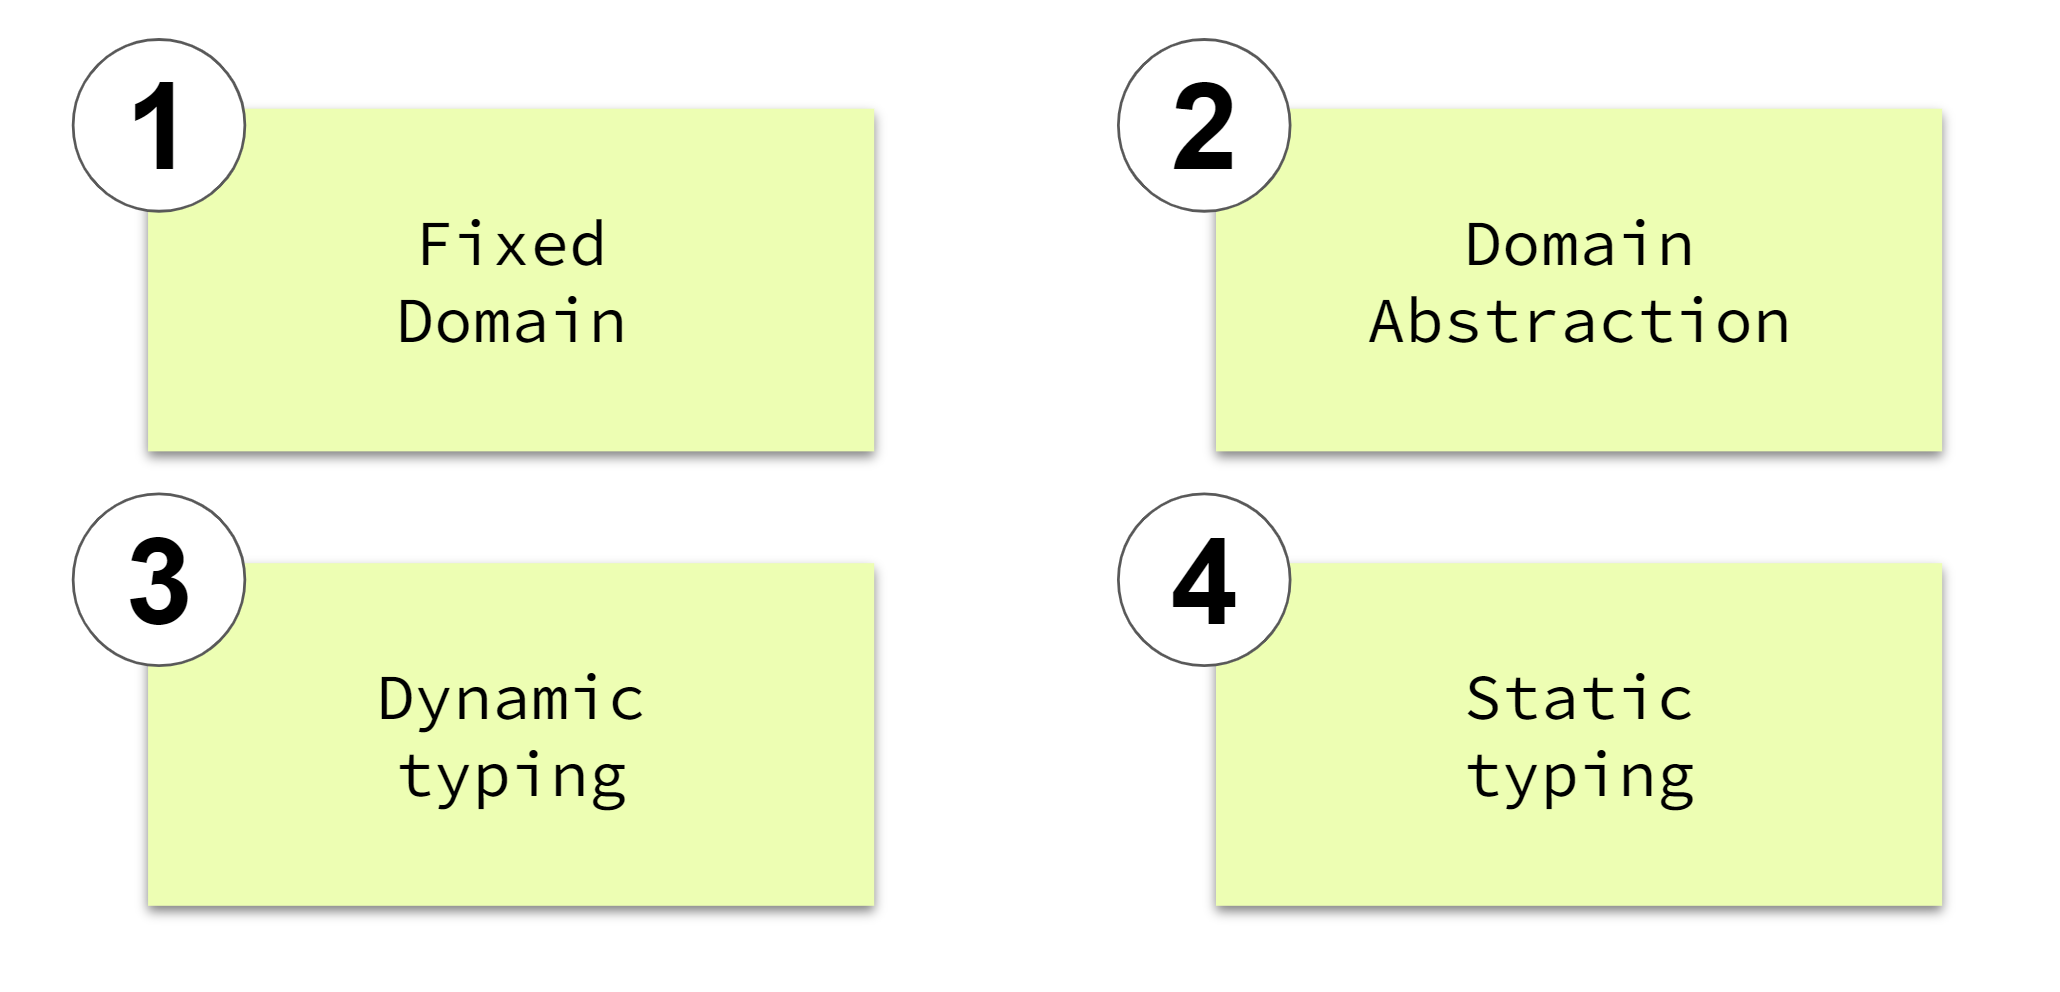

# Conclusion

* _What do DSLs offer in relation to problem-solving and computing in general?_
  * They allow reasoning at a higher level of abstraction, without needing to focus on low-level implementation details.
<br/><br/>
* _How do DSLs relate to functional programming?_
  * A functional architecture is often built around a stack of DSLs, compilers, and interpreters, which together produce the desired side effects.


# References

* Github API: https://docs.github.com/en/rest?apiVersion=2022-11-28
* fs2: https://fs2.io/#/
* circe: https://github.com/circe/circe
* `Monocle`: https://fs2.io/#/
* `Jq`: https://jqlang.github.io/jq/
* Optics alternative to jq: https://chrispenner.ca/posts/traversal-systems
* Tagless final: https://okmij.org/ftp/tagless-final/index.html